In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from ipywidgets import interactive
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [71]:
base_path = 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset'

In [72]:
base_path

'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset'

In [73]:
scans = os.path.join(base_path, 'case2', 'case2_day5', 'scans')
contours = os.path.join(base_path, 'case2', 'case2_day5', 'contours','masks_rle.csv')

In [10]:
scans

'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case2\\case2_day5\\scans'

In [11]:
# hand coded color scheme for visualization (order RGB)
default_color_dict = {0 : (255/255., 102/255., 102/255.), #'ampulla_of_vater'
                      1 : (255/255., 178/255., 102/255.), #'large_bowel'
                      2 : (102/255., 255/255., 102/255.), #'pyloric_sphincter'
                      3 : (102/255., 255/255., 255/255.), #'small_bowel'
                      4 : (178/255., 102/255., 255/255.)} #'stomach'
# reference dict for mask type
mask_dict = {0 : 'ampulla of vater',
             1 : 'large bowel',
             2 : 'pyloric sphincter',
             3 : 'small bowel',
             4 : 'stomach'}

In [242]:
def process_image(img):
    gamma = 0.6
    img = img.astype(np.float32)
    img = img ** gamma
    if np.max(img) == 0:
        return np.zeros_like(img)
    else:
        img = img / np.max(img)
    return img

In [13]:
def rle_decode(mask_rle, shape, dtype=np.uint8):
    '''
    Helper function for run-length decoding
    ref.: https://www.kaggle.com/stainsby/fast-tested-rle
    Inputs:
        mask_rle: string formated RLE
        shape: (height,width) of array to return
        dtype: data type of array to return (default: uint8)
    Returns
        numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=dtype)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [15]:

# for root, dir, files in os.walk(scans):
#     for file in files:
#         img = cv2.imread(os.path.join(root, file), 0)
#         img = process_image(img)
#         img = np.tile(img[:,:,np.newaxis], (1, 1, 3))
#         df = pd.read_csv(contours)
       
#         slice_id = file[:10]
#         alpha = 0.7
#         df = df[df['SliceID'] ==  slice_id]
#         w, h = df['ImgShape (WxH)'].iloc[0].split()
#         h,w = int(w), int(h)
#         assert h==img.shape[1] and w==img.shape[0]
#         seg_mask = np.zeros((w, h, 3), dtype=np.float32)
#         blurred = cv2.GaussianBlur(img, (9,9), 10)
#         kmeans = KMeans(n_clusters=2)
#         try:
#             labels = kmeans.fit_predict(blurred.reshape(-1,3))
#         except ValueError:
#             continue
#         labels_arr, counts =  np.unique(labels,  return_counts=True)
#         slice_ids.append(slice_id)
#         X_train.append(img)
#         whiteness.append(np.mean(img))
#         if  counts[0] < counts[1]:
#             labels[np.where(labels == 0)] = -1
#             labels[np.where(labels == 1)] = 0
#             labels[np.where(labels == -1)] = 1
#         labels = labels.reshape(blurred.shape[0], blurred.shape[1])
#         cur_color = np.array(
#         (255/255., 255/255., 255/255.)).reshape(1, 1, 3)
#         color_map = np.tile(cur_color, (w, h, 1))
#         # print(seg_mask.shape, color_map.shape, labels.shape)
#         seg_mask += ((-0.3 * seg_mask + 0.3 * color_map) *np.tile(labels[:,:,np.newaxis], (1,1,3)))
#         for i in range(len(df)):
#             mask_rle = df['EncodedPixels'].iloc[i]
#             if mask_rle != -1 and mask_rle != '':
#                 mask = rle_decode(mask_rle, shape=(w, h),dtype= np.float32)
#                 mask = np.tile(mask[:,:,np.newaxis], (1,1,3))
#                 color_mask = np.float32(default_color_dict[i])
#                 color_mask = np.tile(color_mask, (w,h,1))
#                 seg_mask+= ((alpha-1)* seg_mask + (1 - alpha)*color_mask)*mask
#         seg_mask = np.clip(255 * seg_mask, 0, 255)
#         y_train.append(seg_mask.astype('uint8'))
#     break
        
        
        

In [17]:
scans

'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case2\\case2_day5\\scans'

In [49]:
os.path.join('case2', 'case2_day1')

'case2\\case2_day1'

In [65]:
samples = []
for root, dirs, files in os.walk(base_path):
    if 'contours' in root:
       samples.append(os.path.dirname(root))

In [66]:
len(samples)

467

In [67]:
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=101)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=101)

In [68]:
len(samples_train), len(samples_test), len(samples_val)

(317, 56, 94)

In [69]:
VOLUME_SLICES = 70
VOLUME_START_AT = 45

In [243]:
IMG_SIZE = 128

class ImageProcessor(tf.keras.utils.Sequence):
    def __init__(self, image_ids, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=True):
        self.image_ids = image_ids
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_ids)/ self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #batch = 1 means batch_id will have 1 element, batch = 10, batch_ids will have 10 elemets
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.image_ids[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y
    
    def load_scans(self, scans_path, contours_path):
        for root, dir, files in os.walk(scans_path):
            seg_mask = np.zeros((len(files), 256, 256), dtype=np.float32)
            raw_scans = np.zeros((len(files), 256, 256), dtype=np.float32)
            for i, file in enumerate(files): 
                img = cv2.imread(os.path.join(root, file), 0)
                img = process_image(img)
                df = pd.read_csv(contours_path)
                slice_id = file[:10]
                df = df[df['SliceID'] ==  slice_id]
                w, h = df['ImgShape (WxH)'].iloc[0].split()
                h,w = int(w), int(h)
                assert h==img.shape[1] and w==img.shape[0]
                if seg_mask.shape[1]!=w and seg_mask.shape[2]!=h:
                    seg_mask = np.zeros((len(files), w, h), dtype=np.float32)
                    raw_scans = np.zeros((len(files), w, h), dtype=np.float32)
                dummy_mask = np.zeros((w, h), dtype=np.float32)
                for j in range(len(df)):
                    mask_rle = df['EncodedPixels'].iloc[j]
                    mask = np.zeros((w, h), dtype=np.float32)
                    if mask_rle != -1 and mask_rle != '-1' and mask_rle != '':
                        mask = rle_decode(mask_rle, shape=(w, h),dtype= np.float32)
                    # plt.imshow(mask)
                    # plt.show()
                    dummy_mask[mask==1] = 0
                    mask[mask==1] = j+1
                    dummy_mask+= mask
                seg_mask[i,:,:] = dummy_mask
                raw_scans[i,:,:] = img
            break
        return raw_scans, seg_mask
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, patient_path in enumerate(Batch_ids):
            # Get path of each RMI modality and the segmentation
            scans_path = os.path.join(patient_path, 'scans')
            contours_path = os.path.join(patient_path, 'contours','masks_rle.csv')
            
            # Extract the data from these paths
            raw_scans, seg = self.load_scans(scans_path, contours_path)
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
            
            
        
            for j in range(VOLUME_SLICES):
                #arithmetic series
                X[j +VOLUME_SLICES*c,:,:] = cv2.resize(raw_scans[j+VOLUME_START_AT,:,:], (IMG_SIZE, IMG_SIZE))
                if y.shape[1]!=seg.shape[1] and y.shape[2]!=seg.shape[2]:
                    y = np.zeros((self.batch_size*VOLUME_SLICES, *seg.shape[1:]))
                y[j +VOLUME_SLICES*c] = seg[j+VOLUME_START_AT,:,:]
                    
        # Masks / Segmentations
        mask = tf.one_hot(y, 6)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y

In [244]:
training_generator = ImageProcessor(samples_train)
valid_generator = ImageProcessor(samples_val)
test_generator = ImageProcessor(samples_test)

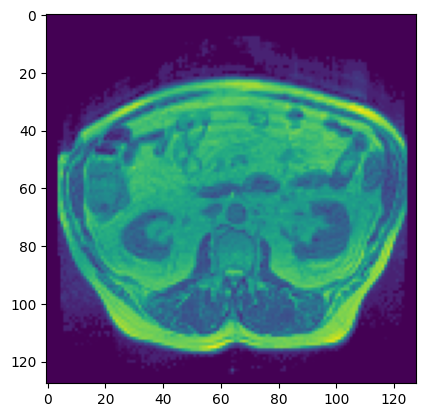

In [255]:
plt.figure()
plt.imshow(training_generator[10][0][50,:,:]+training_generator[10][1][50,:,:,5], cmap='viridis')

In [257]:
len(training_generator)

317

In [256]:
def show_slices(patient_id, slice_id, segment):
    plt.imshow(training_generator[patient_id][0][slice_id,:,:]+training_generator[patient_id][1][slice_id,:,:,segment], cmap='viridis')
    plt.show()

In [ ]:
iplot = interactive(show_slices, patient_id=(0, len(training_generator)-1),slice_id= (0,69), segment = (0, 5))

In [260]:
iplot

interactive(children=(IntSlider(value=158, description='patient_id', max=316), IntSlider(value=34, description…

In [74]:
# for root, dirs, files in os.walk(base_path):
#     if 'scan' in root:
#         contours_path = os.path.join(os.path.dirname(root), 'contours','masks_rle.csv')
#         scans_path = root
#         X_scans = []
#         y_scans = []
#         slice_ids = []
#         whiteness = []
#         for file in files:
#             og_img = cv2.imread(os.path.join(scans_path, file), 0)
#             img = process_image(og_img)
#             img = np.tile(img[:,:,np.newaxis], (1, 1, 3))
#             df = pd.read_csv(contours_path)
            
#             slice_id = file[:10]
#             alpha = 0.7
#             df = df[df['SliceID'] ==  slice_id]
#             w, h = df['ImgShape (WxH)'].iloc[0].split()
#             h,w = int(w), int(h)
#             try:
#                 assert h==img.shape[1] and w==img.shape[0]
#             except AssertionError:
#                 continue
#             seg_mask = np.zeros((w, h, 3), dtype=np.float32)
#             blurred = cv2.GaussianBlur(img, (9,9), 10)
#             kmeans = KMeans(n_clusters=2)
#             try:
#                 labels = kmeans.fit_predict(blurred.reshape(-1,3))
#             except ValueError:
#                 continue
#             sorted_labels, counts =  np.unique(labels,  return_counts=True)
#             if  labels[0] != sorted_labels[0]:
#                 labels[np.where(labels == 0)] = -1
#                 labels[np.where(labels == 1)] = 0
#                 labels[np.where(labels == -1)] = 1
#             labels = labels.reshape(blurred.shape[0], blurred.shape[1])
#             cur_color = np.array(
#             (255/255., 255/255., 255/255.)).reshape(1, 1, 3)
#             color_map = np.tile(cur_color, (w, h, 1))
#             # print(seg_mask.shape, color_map.shape, labels.shape)
#             seg_mask += ((-0.3 * seg_mask + 0.3 * color_map) *np.tile(labels[:,:,np.newaxis], (1,1,3)))
#             for i in range(len(df)):
#                 mask_rle = df['EncodedPixels'].iloc[i]
#                 if mask_rle != -1 and mask_rle != '':
#                     mask = rle_decode(mask_rle, shape=(w, h),dtype= np.float32)
#                     mask = np.tile(mask[:,:,np.newaxis], (1,1,3))
#                     color_mask = np.float32(default_color_dict[i])
#                     color_mask = np.tile(color_mask, (w,h,1))
#                     seg_mask+= ((alpha-1)* seg_mask + (1 - alpha)*color_mask)*mask
#             seg_mask = np.clip(255 * seg_mask, 0, 255)
#             slice_ids.append(slice_id)
#             X_scans.append(og_img)
#             whiteness.append(np.mean(img))
#             y_scans.append(seg_mask.astype('uint8'))
#         if np.sum(whiteness) < 8:
#             continue
#         else:
#             X.append(X_scans)
#             y.append(y_scans)
#             masks_path = os.path.join(os.path.dirname(root), 'masks')
#             valid_scans_path = os.path.join(os.path.dirname(root), 'valid_scans')
#             print(masks_path)
#             try:
#                 os.makedirs(masks_path)
#                 print(masks_path, 'created!')
#             except FileExistsError:
#                 print('masks_path exists')
#             try:
#                 os.makedirs(valid_scans_path)
#                 print(valid_scans_path, 'created!')
#             except FileExistsError:
#                 print('valid_scans_path exists')
#             # [cv2.imwrite(os.path.join(valid_scans_path, f'{slice_ids[i]}.png') , img) for i, img in enumerate(X_scans)]
#             # [cv2.imwrite(os.path.join(masks_path, f'{slice_ids[i]}.png') , cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) for i, img in enumerate(y_scans)]
